In [1]:
from pysjef import Project, DirectoryNode, all_completed
from pysjef_molpro import no_errors
import numpy
import matplotlib.pyplot as plt

In [2]:
root = DirectoryNode('scan')

In [3]:
p = root.add_child('d0', suffix='molpro')
p.write_input("""file,2,mrci.wf
nosym
geometry={
    H1
    C1 H1 rch
    C2 C1 rcc H1 A
    H2 C2 rch C1 A H1 D
    H3 C2 rch C1 A H2 180
    H4 C1 rch C2 A H1 180}
rch = 2.05
rcc = 2.85
A = 121.5
D = 90.0
basis = cc-pVTZ
rhft; AVAS; CENTER, 2, 2p; CENTER, 3, 2p;
{casscf; closed, 7; occ, 9}
optg; inactive, D
{casscf, so_sci; closed, 7; occ, 9; wf; state, 2}
{mrci; core, 4; wf; state, 2;}""")
p.write_file('molpro.rc', content='-W .')
p.run(wait=True)
if p.errors(): raise RuntimeError('reference job failed')

In [4]:
grid = numpy.linspace(0, 90, 21)[::-1]
for i in range(1, grid.size):
    p = root.child(name=f'd{i-1}').copy(f'd{i}', force=True)
    p.write_input(f"""file,2,mrci.wf
        D = {grid[i]}
        {{casscf; closed, 7; occ, 9}}
        optg; inactive, D
        {{casscf, so_sci; closed, 7; occ, 9; wf; state, 2}}
        {{mrci; core, 4; wf; state, 2;}}""")
    p.run(backend='local', wait=True)
    if p.errors(): raise RuntimeError(f'job failed index={i}, D={D}')
    root.add_child_node(p, replace=True)

<IPython.core.display.Javascript object>


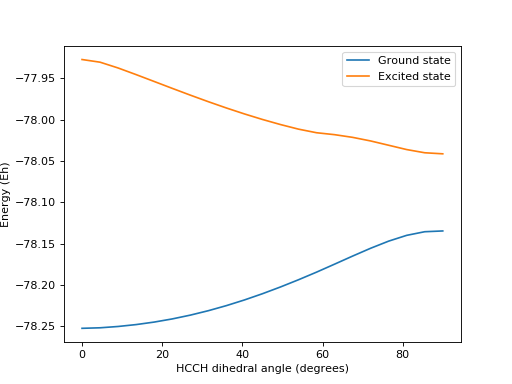

In [5]:
%matplotlib notebook
energies = root.select('//property[name=Energy, method=MRCI].value')
e1, e2 = energies[::2], energies[1::2]
cc = root.select('//variable[name=rcc]/value..')
ch = root.select('//variable[name=rch]/value..')
ang = root.select('//variable[name=A]/value..')
plt.plot(grid, e1, grid, e2)
plt.legend(['Ground state','Excited state'])
plt.xlabel('HCCH dihedral angle (degrees)')
plt.ylabel('Energy (Eh)')
plt.show()